In [1]:
# Standard imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
# Local module imports
import sys
import os
sys.path.append(os.path.abspath('../'))

from src.preprocessing.cleaning import handle_missing_values, remove_duplicates, convert_to_datetime
from src.preprocessing.feature_engineering import extract_time_features, convert_ip_to_int, merge_ip_country
from src.preprocessing.transform import encode_categorical, scale_features, handle_imbalance
from src.preprocessing.utils import load_csv, save_csv


In [2]:
# Load the dataset
credit_df = pd.read_csv("../data/raw/creditcard.csv")

# Check class distribution
print(credit_df['Class'].value_counts())

Class
0    284315
1       492
Name: count, dtype: int64


In [12]:
print(credit_df.head())
credit_df.info()
credit_df.describe()
print(credit_df.isnull().sum())
credit_df.dtypes


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [3]:
# Split features and target variable

Xc = credit_df.drop(columns=['Class'])  # Features
yc = credit_df['Class']                # Target

# Train-Test Split

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    Xc, yc, test_size=0.2, stratify=yc, random_state=42
)


In [4]:
# Scale Features
def scale_cr_features(X_train, X_test, method="standard"):
    if method == "standard":
        scaler = StandardScaler()
    elif method == "minmax":
        scaler = MinMaxScaler()
    else:
        raise ValueError("Invalid method. Choose 'standard' or 'minmax'.")

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, scaler

Xc_train_scaled, Xc_test_scaled, scaler = scale_cr_features(Xc_train, Xc_test)

# Convert to DataFrames again for easier exploration
Xc_train_scaled_df = pd.DataFrame(Xc_train_scaled, columns=Xc.columns)
Xc_test_scaled_df = pd.DataFrame(Xc_test_scaled, columns=Xc.columns)

# Final Check
print("Final training set shape:", Xc_train_scaled_df.shape)
print("Final test set shape:", Xc_test_scaled_df.shape)
print("Resampled class distribution:", pd.Series(yc_train).value_counts())



Final training set shape: (227845, 30)
Final test set shape: (56962, 30)
Resampled class distribution: Class
0    227451
1       394
Name: count, dtype: int64


In [5]:
# Handle Class Imbalance (SMOTE)

Xc_train_bal, yc_train_bal = handle_imbalance(Xc_train_scaled, yc_train)


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, average_precision_score
import pandas as pd
import numpy as np

# Define models to try
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
}

# Store results
results = []
confusion_matrices = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model on balanced data
    model.fit(Xc_train_bal, yc_train_bal)
    
    # Predict on the un-balanced test set
    y_pred = model.predict(Xc_test_scaled)
    
    # Get probabilities for metrics
    y_proba = model.predict_proba(Xc_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Evaluate
    acc = accuracy_score(yc_test, y_pred)
    prec = precision_score(yc_test, y_pred, zero_division=0)
    rec = recall_score(yc_test, y_pred)
    f1 = f1_score(yc_test, y_pred)
    
    # Use AUC-PR for imbalanced data, in addition to AUC-ROC
    auc_roc = roc_auc_score(yc_test, y_proba) if y_proba is not None else "N/A"
    auc_pr = average_precision_score(yc_test, y_proba) if y_proba is not None else "N/A"
    
    # Store confusion matrix for later analysis
    cm = confusion_matrix(yc_test, y_pred)
    confusion_matrices[name] = cm
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "AUC-ROC": auc_roc,
        "AUC-PR": auc_pr
    })

# Convert to DataFrame
results_df = pd.DataFrame(results).sort_values(by="AUC-PR", ascending=False)
print("\n📊 Model Comparison:\n")
print(results_df.reset_index(drop=True))

print("\n--- Confusion Matrices ---")
for name, cm in confusion_matrices.items():
    print(f"\n{name} Confusion Matrix:")
    print(cm)
    # Explain the matrix
    tn, fp, fn, tp = cm.ravel()
    print(f"  True Negatives (Correctly identified non-fraud): {tn}")
    print(f"  False Positives (Incorrectly flagged as fraud): {fp}")
    print(f"  False Negatives (Missed fraud cases): {fn}")
    print(f"  True Positives (Correctly identified fraud): {tp}")


Training Logistic Regression...

Training Random Forest...

Training Gradient Boosting...

Training XGBoost...


c:\Users\mike\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:02:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Model Comparison:

                 Model  Accuracy  Precision    Recall  F1 Score   AUC-ROC  \
0        Random Forest  0.999491   0.870968  0.826531  0.848168  0.968448   
1              XGBoost  0.999192   0.728070  0.846939  0.783019  0.979983   
2    Gradient Boosting  0.987500   0.113350  0.918367  0.201794  0.980965   
3  Logistic Regression  0.974106   0.057803  0.918367  0.108761  0.970843   

     AUC-PR  
0  0.872440  
1  0.868282  
2  0.741014  
3  0.724469  

--- Confusion Matrices ---

Logistic Regression Confusion Matrix:
[[55397  1467]
 [    8    90]]
  True Negatives (Correctly identified non-fraud): 55397
  False Positives (Incorrectly flagged as fraud): 1467
  False Negatives (Missed fraud cases): 8
  True Positives (Correctly identified fraud): 90

Random Forest Confusion Matrix:
[[56852    12]
 [   17    81]]
  True Negatives (Correctly identified non-fraud): 56852
  False Positives (Incorrectly flagged as fraud): 12
  False Negatives (Missed fraud cases): 17
  T

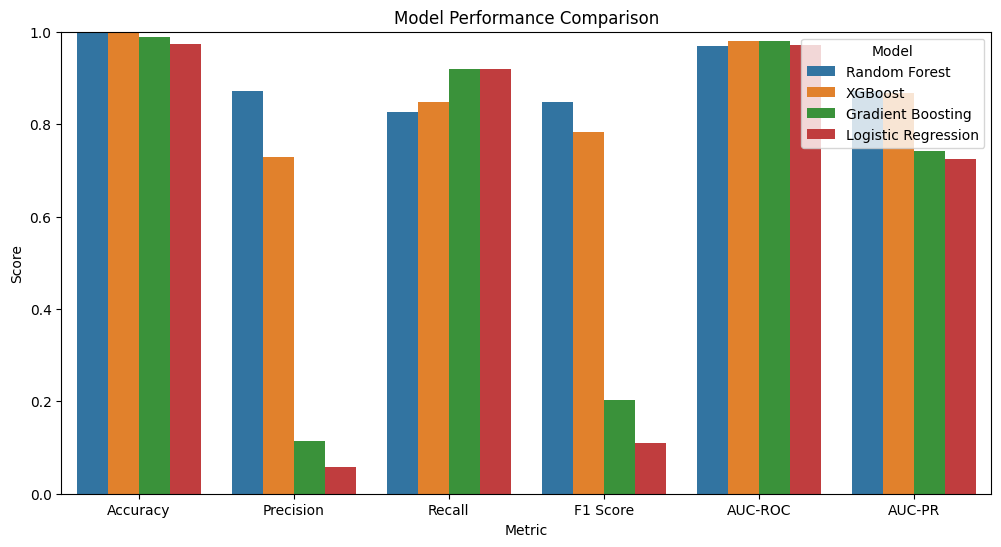

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming results_df is your model comparison DataFrame
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC', 'AUC-PR']
results_melted = results_df.melt(id_vars='Model', value_vars=metrics, var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=results_melted, x='Metric', y='Score', hue='Model')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.show()


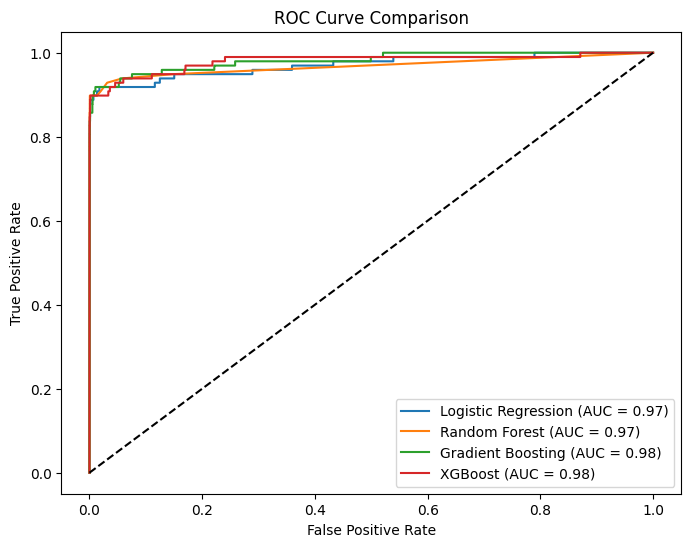

In [15]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))

for name, model in models.items():
    y_proba = model.predict_proba(Xc_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(yc_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()



--- SHAP Analysis for Logistic Regression ---

Skipping SHAP analysis for Random Forest due to long computation time.

--- SHAP Analysis for Gradient Boosting ---
Generating SHAP Summary Plot for Gradient Boosting...


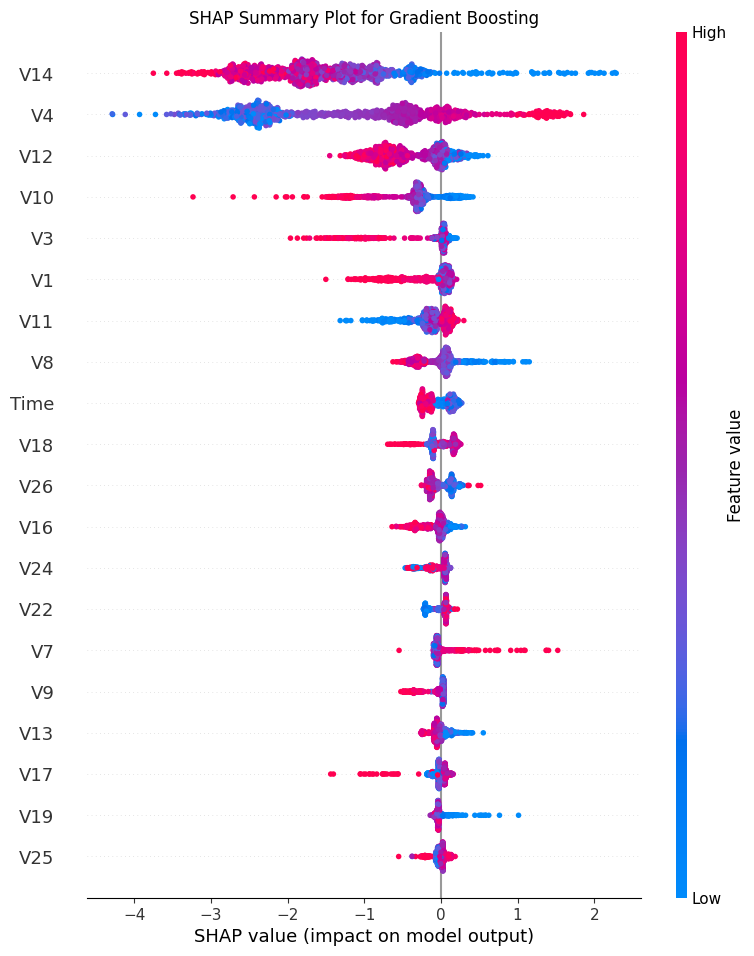

Generating SHAP Force Plot for a True Positive from Gradient Boosting...


c:\Users\mike\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(



--- SHAP Analysis for XGBoost ---
Generating SHAP Summary Plot for XGBoost...


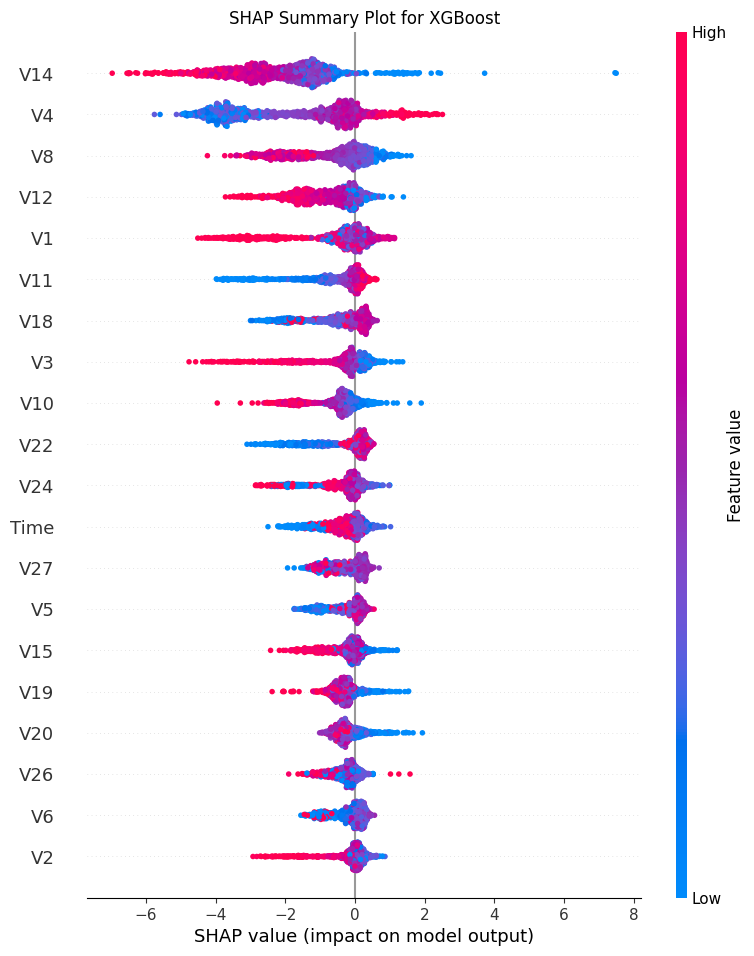

Generating SHAP Force Plot for a True Positive from XGBoost...


In [ ]:
# SHAP Analysis for Model Interpretability
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Create a stratified sample for SHAP
sample_size = 1000
X_test_scaled_df = pd.DataFrame(Xc_test_scaled, columns=Xc.columns)
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=sample_size, random_state=42)
for _, test_index in sss.split(X_test_scaled_df, yc_test):
    X_test_sample = X_test_scaled_df.iloc[test_index]
    y_test_sample = yc_test.iloc[test_index]

# Loop through all models and generate SHAP plots, but skipped Random Forest for now
for name, model in models.items():
    if name == "Random Forest":
        print(f"\nSkipping SHAP analysis for {name} due to long computation time.")
        continue

    print(f"\n--- SHAP Analysis for {name} ---")

    # Use TreeExplainer for tree-based models
    if "Logistic Regression" not in name:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test_sample)

        # Generate and interpret SHAP Summary Plot
        print(f"Generating SHAP Summary Plot for {name}...")
        shap.summary_plot(shap_values, X_test_sample, show=False)
        plt.title(f'SHAP Summary Plot for {name}')
        plt.show()

        # Generate Force Plots for each model
        # Find an example of a True Positive
        tp_index = np.where((model.predict(X_test_sample) == 1) & (y_test_sample == 1))[0]
        if len(tp_index) > 0:
            tp_instance_index = tp_index[0]
            print(f"Generating SHAP Force Plot for a True Positive from {name}...")
            shap.initjs()
            display(shap.force_plot(explainer.expected_value, shap_values[tp_instance_index,:], X_test_sample.iloc[tp_instance_index,:]))
        else:
            print(f"Could not find a True Positive example for {name} in the sample.")